# Post Test set

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_post_dataset/test/9353628_20140129_MOLLI_1.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
# low, sparse, U, S, V = rpca_godec(M, rank=5)
# low_matrix = low.reshape((x, y, z))
# sparse_matrix = sparse.reshape((x, y, z))

# fig = plt.figure(figsize=(11, 3))
# title_font_size=8
# title_pad = 10
# for i in range(z):
#     ax1 = fig.add_subplot(3, 11, 1+i)
#     plt.imshow(vols[..., i], cmap='gray')
#     plt.axis('off')
#     ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

#     ax2 = fig.add_subplot(3, 11, 12+i)
#     plt.imshow(low_matrix[..., i], cmap='gray')
#     plt.axis('off')

#     ax3 = fig.add_subplot(3, 11, 23+i)
#     plt.imshow(sparse_matrix[..., i], cmap='gray')
#     plt.axis('off')

x is 224 and y is 224 and z is 11
(50176, 11)


In [2]:
import pandas as pd
df = pd.DataFrame()
df_2 = pd.DataFrame()

## Test Metrics

### Original volume

#### First Eigen Component percentage

In [3]:
from scripts.utils import *
orig_path = 'data/MOLLI_post_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.8590354716904918


#### T1 fitting

In [4]:
import scipy.io
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

title_font_size=8
title_pad = 10
def plot_t1_changes(path, size=(20, 36)):
    fig = plt.figure(figsize=size)
    t1err_square_list = []
    t1err_heart_list = []
    t1err_myo_list = []
    subject_list = []
    
    neighbor = ndimage.generate_binary_structure(2, 2)
    for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
        subject = Path(file).stem
        subject_list.append(subject)
        fd = scipy.io.loadmat(file)
        SD_err = fd['S']
        areamask = fd['areamask']
        itemindex = np.where(areamask == 1)
        x1, x2 = itemindex[0][0], itemindex[0][-1]
        y1, y2 = itemindex[1][0], itemindex[1][-1]
        epi = fd['epi_BW']
        endo = fd['endo_BW']
        heartmask = ndimage.binary_dilation(epi, structure=neighbor, iterations=3).astype(epi.dtype)
        myomask = heartmask - endo
        
        errmap = SD_err * areamask
        square_SD_err = np.mean(errmap[areamask==1])
        t1err_square_list.append(square_SD_err)
        fig.add_subplot(10, 6, 1+i*6)
        ax = plt.gca()
        im = ax.imshow(errmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(square_SD_err):.4f}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        t1_params_pre = fd['pmap_mse']
        a = t1_params_pre[:, :, 0]
        b = t1_params_pre[:, :, 1]
        c = t1_params_pre[:, :, 2]
        t1map = c * (b - 1)
        fig.add_subplot(10, 6, 2+i*6)
        ax = plt.gca()
        im = ax.imshow(t1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        hearterrmap = SD_err * heartmask
        heartt1map = t1map * heartmask
        heart_SD_err = np.mean(hearterrmap[heartmask==1])
        t1err_heart_list.append(heart_SD_err)

        fig.add_subplot(10, 6, 3+i*6)
        ax = plt.gca()
        im = ax.imshow(hearterrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(heart_SD_err):.4f} in ROI", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        fig.add_subplot(10, 6, 4+i*6)
        ax = plt.gca()
        im = ax.imshow(heartt1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        myoerrmap = SD_err * myomask
        myot1map = t1map * myomask
        myo_SD_err = np.mean(myoerrmap[myomask==1])
        t1err_myo_list.append(myo_SD_err)

        fig.add_subplot(10, 6, 5+i*6)
        ax = plt.gca()
        im = ax.imshow(myoerrmap[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=50)
        ax.axis('off')
        ax.set_title(f"Average SD error {(myo_SD_err):.4f} in Myocardium", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        fig.add_subplot(10, 6, 6+i*6)
        ax = plt.gca()
        im = ax.imshow(myot1map[x1:x2, y1:y2], cmap='jet', vmin=0, vmax=2500)
        ax.axis('off')
        ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
    plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
    return fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list

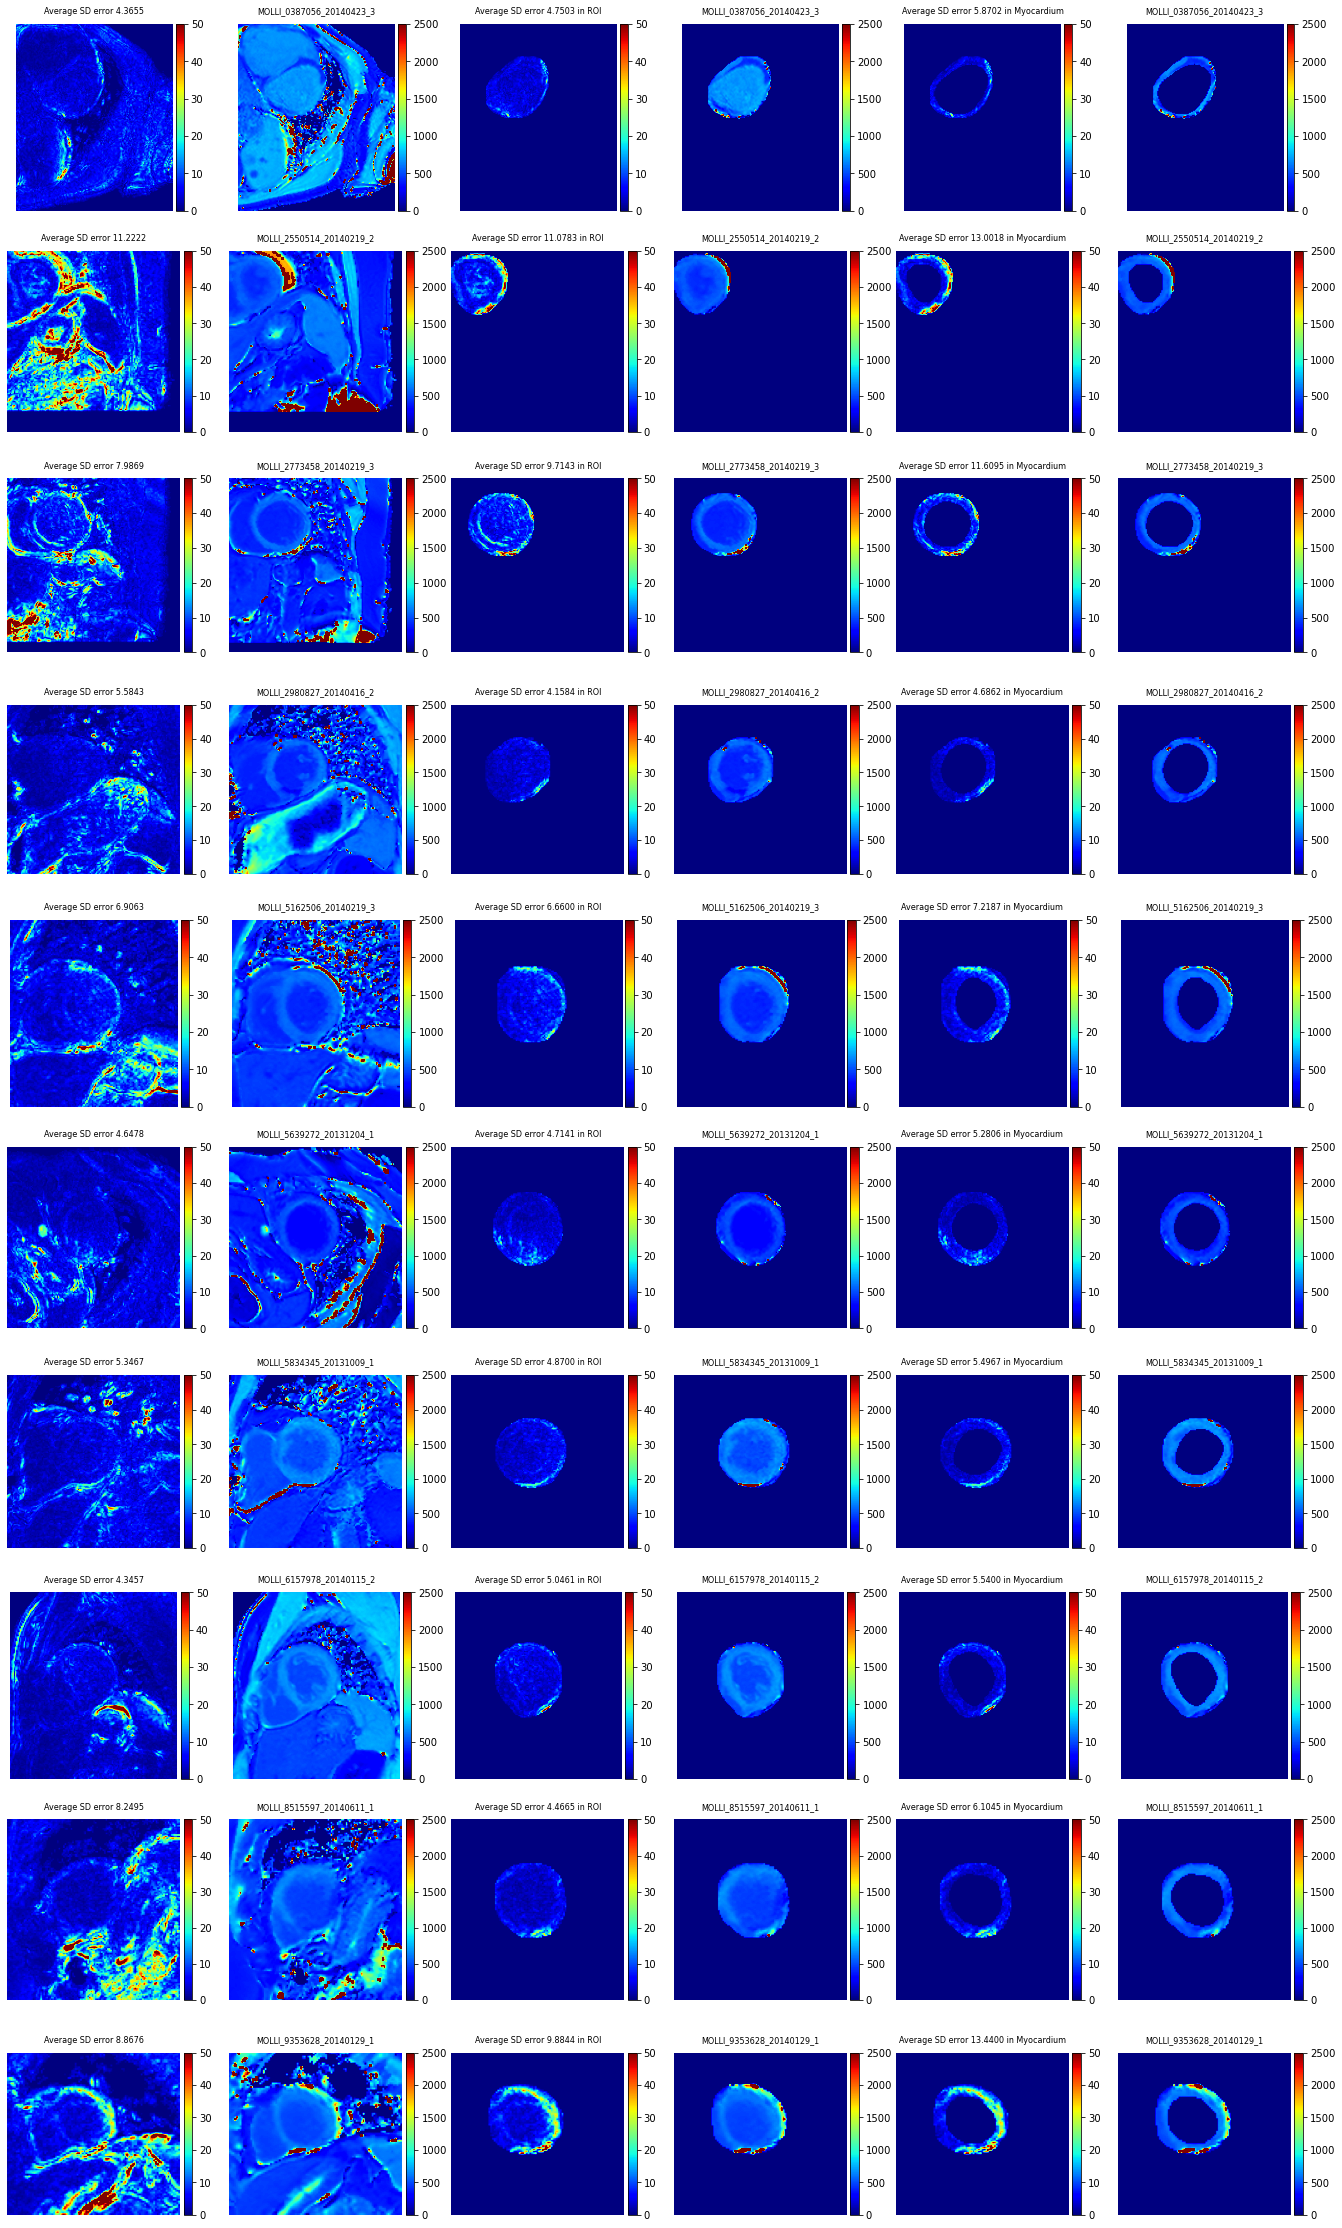

In [5]:
path = "data/MOLLI_post_dataset/T1_SDerr"

fig, subject_list, orig_t1err_square_list, orig_t1err_heart_list, orig_t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"data/MOLLI_post_dataset/T1_SDerr/orig_t1err.png", dpi=300)

df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['Raw ROI T1err'] = orig_t1err_heart_list
df['Raw Myo T1err'] = orig_t1err_myo_list
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes

### Round 1

In [6]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

In [7]:
r = 1
root = f"results/MOLLI_pre/group/rank_11_11_11_11_11_11_11/nmi/smooth/image_loss_weight1/cycle_loss_weight0.01/weight0.001/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_post"
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [8]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 1 PCA is 0.864257978026535 and std is 0.021408447726175686


#### Jacobian Determination

In [9]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.002129071857780218


#### T1 fitting

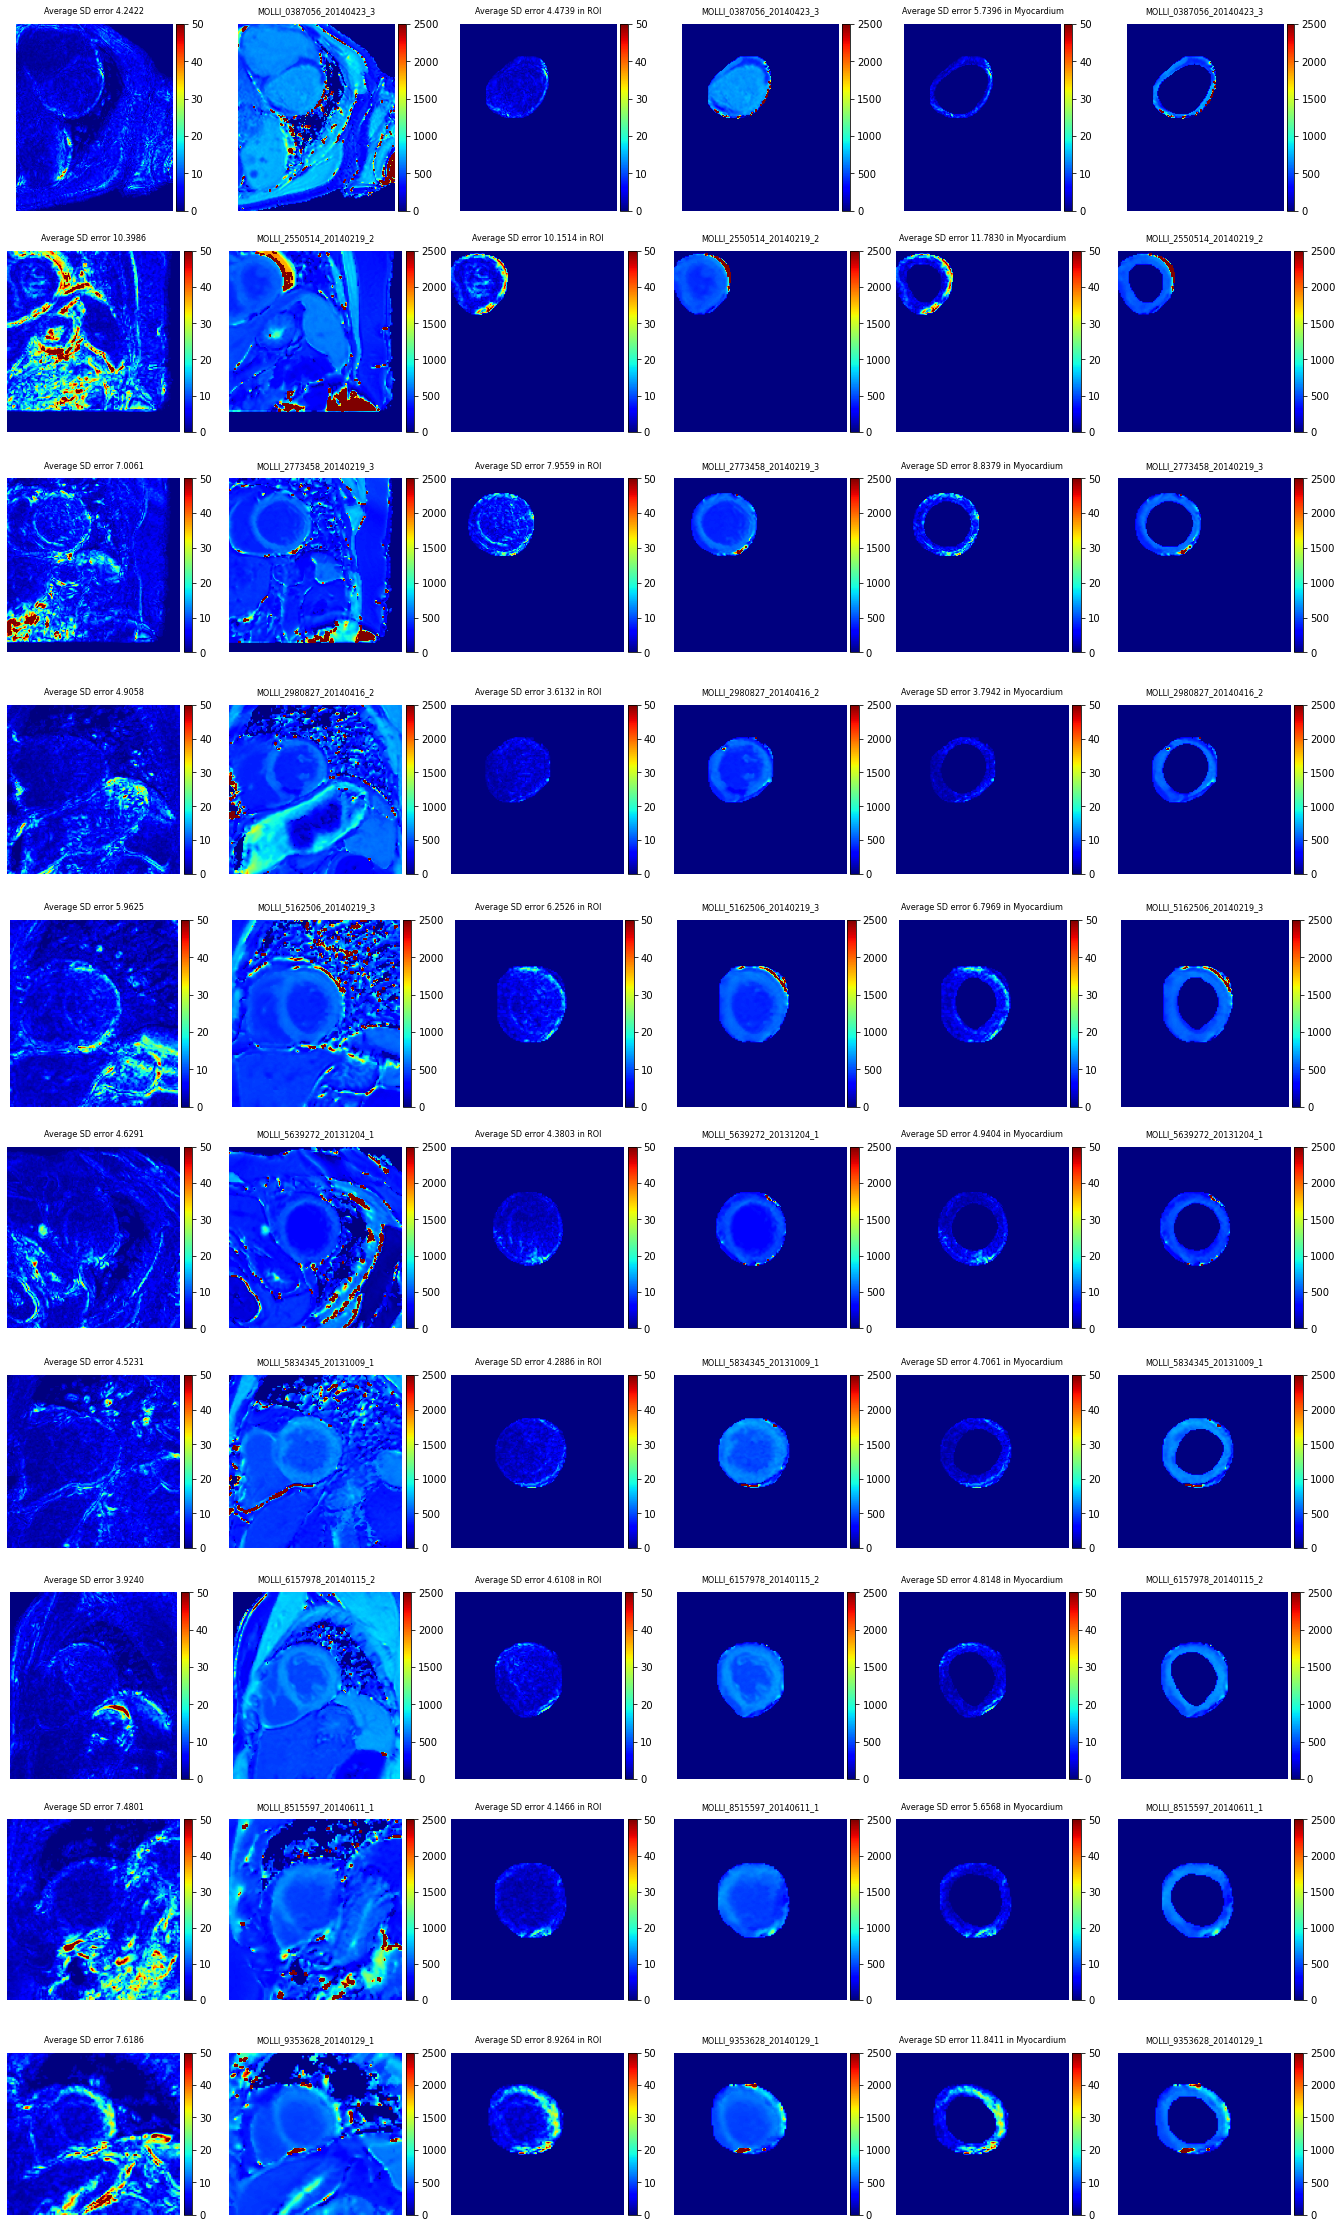

In [10]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R1 Square T1err'] = t1err_square_list
df['R1 ROI T1err'] = t1err_heart_list
df['R1 Myo T1err'] = t1err_myo_list
df_2['R1 PCA'] = pca_changes
df_2['R1 Det'] = mag_det_jac_det_list

### Round 2

In [11]:
r = 2
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [12]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8670391286750488 and std is 0.0208220574837762


#### Jacobian Determination

In [13]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0018081158632412553


#### T1 fitting

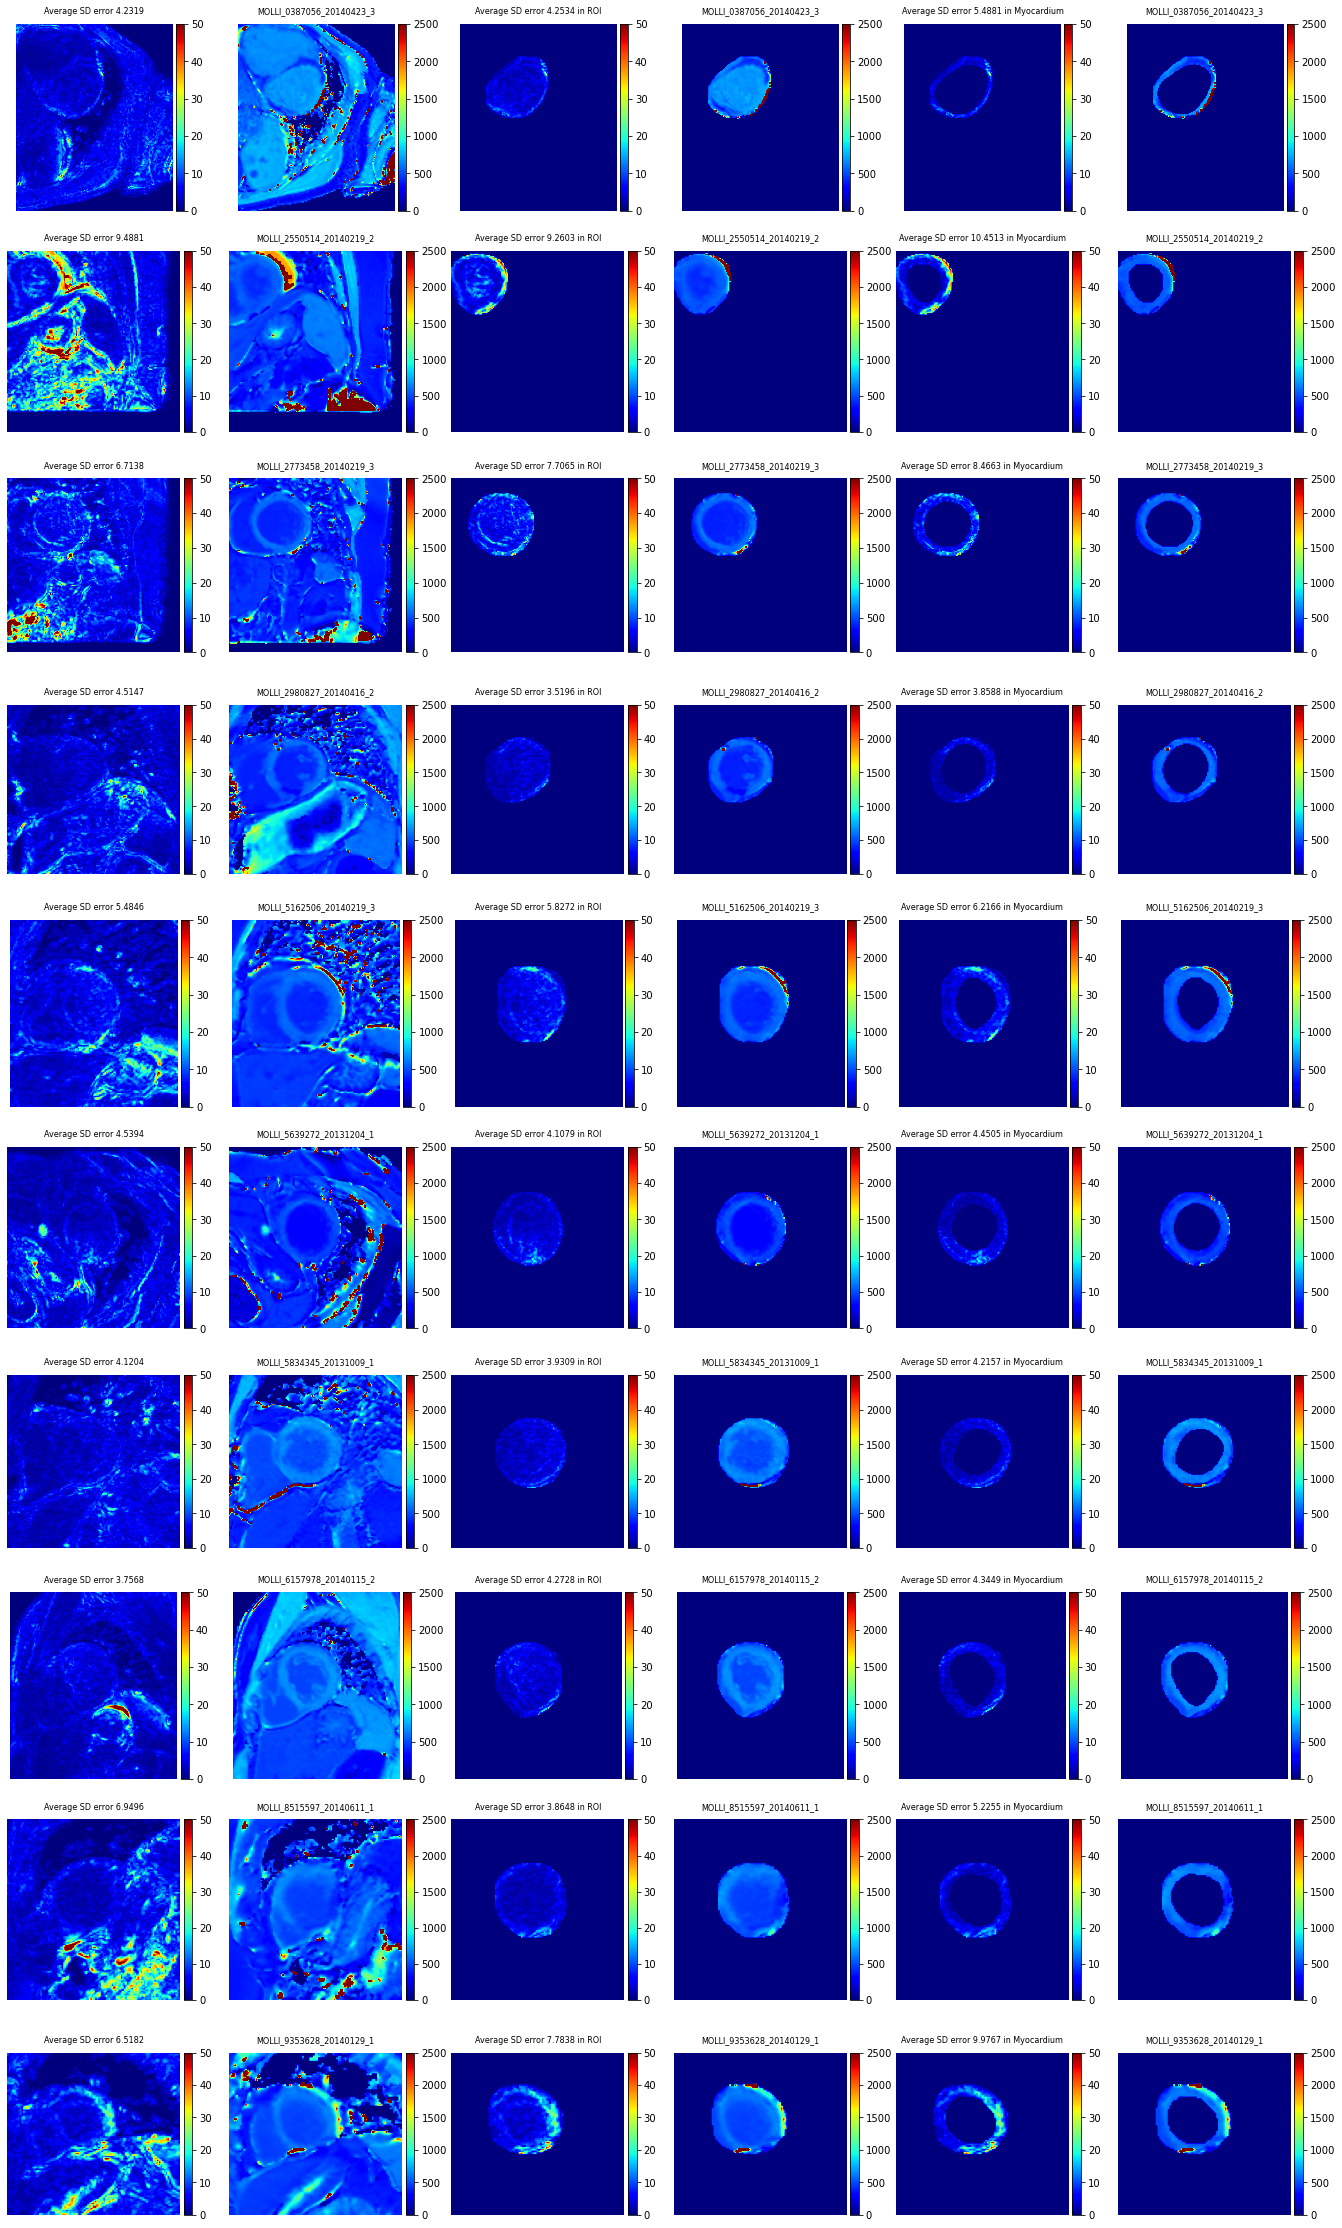

In [14]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R2 Square T1err'] = t1err_square_list
df['R2 ROI T1err'] = t1err_heart_list
df['R2 Myo T1err'] = t1err_myo_list
df_2['R2 PCA'] = pca_changes
df_2['R2 Det'] = mag_det_jac_det_list

### Round 3

In [15]:
r = 3
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [16]:
path = f"{base_path}/moved"
r5_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r5_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r5_pca_changes))} and std is {np.std(np.array(r5_pca_changes))}")

Mean of Round 2 PCA is 0.8689032898139356 and std is 0.020492388446334577


#### Jacobian Determination

In [17]:
r5_folding_ratio_list = []
r5_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r5_folding_ratio_list.append(folding_ratio)
    r5_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r5_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r5_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0015152811538428068


#### T1 fitting

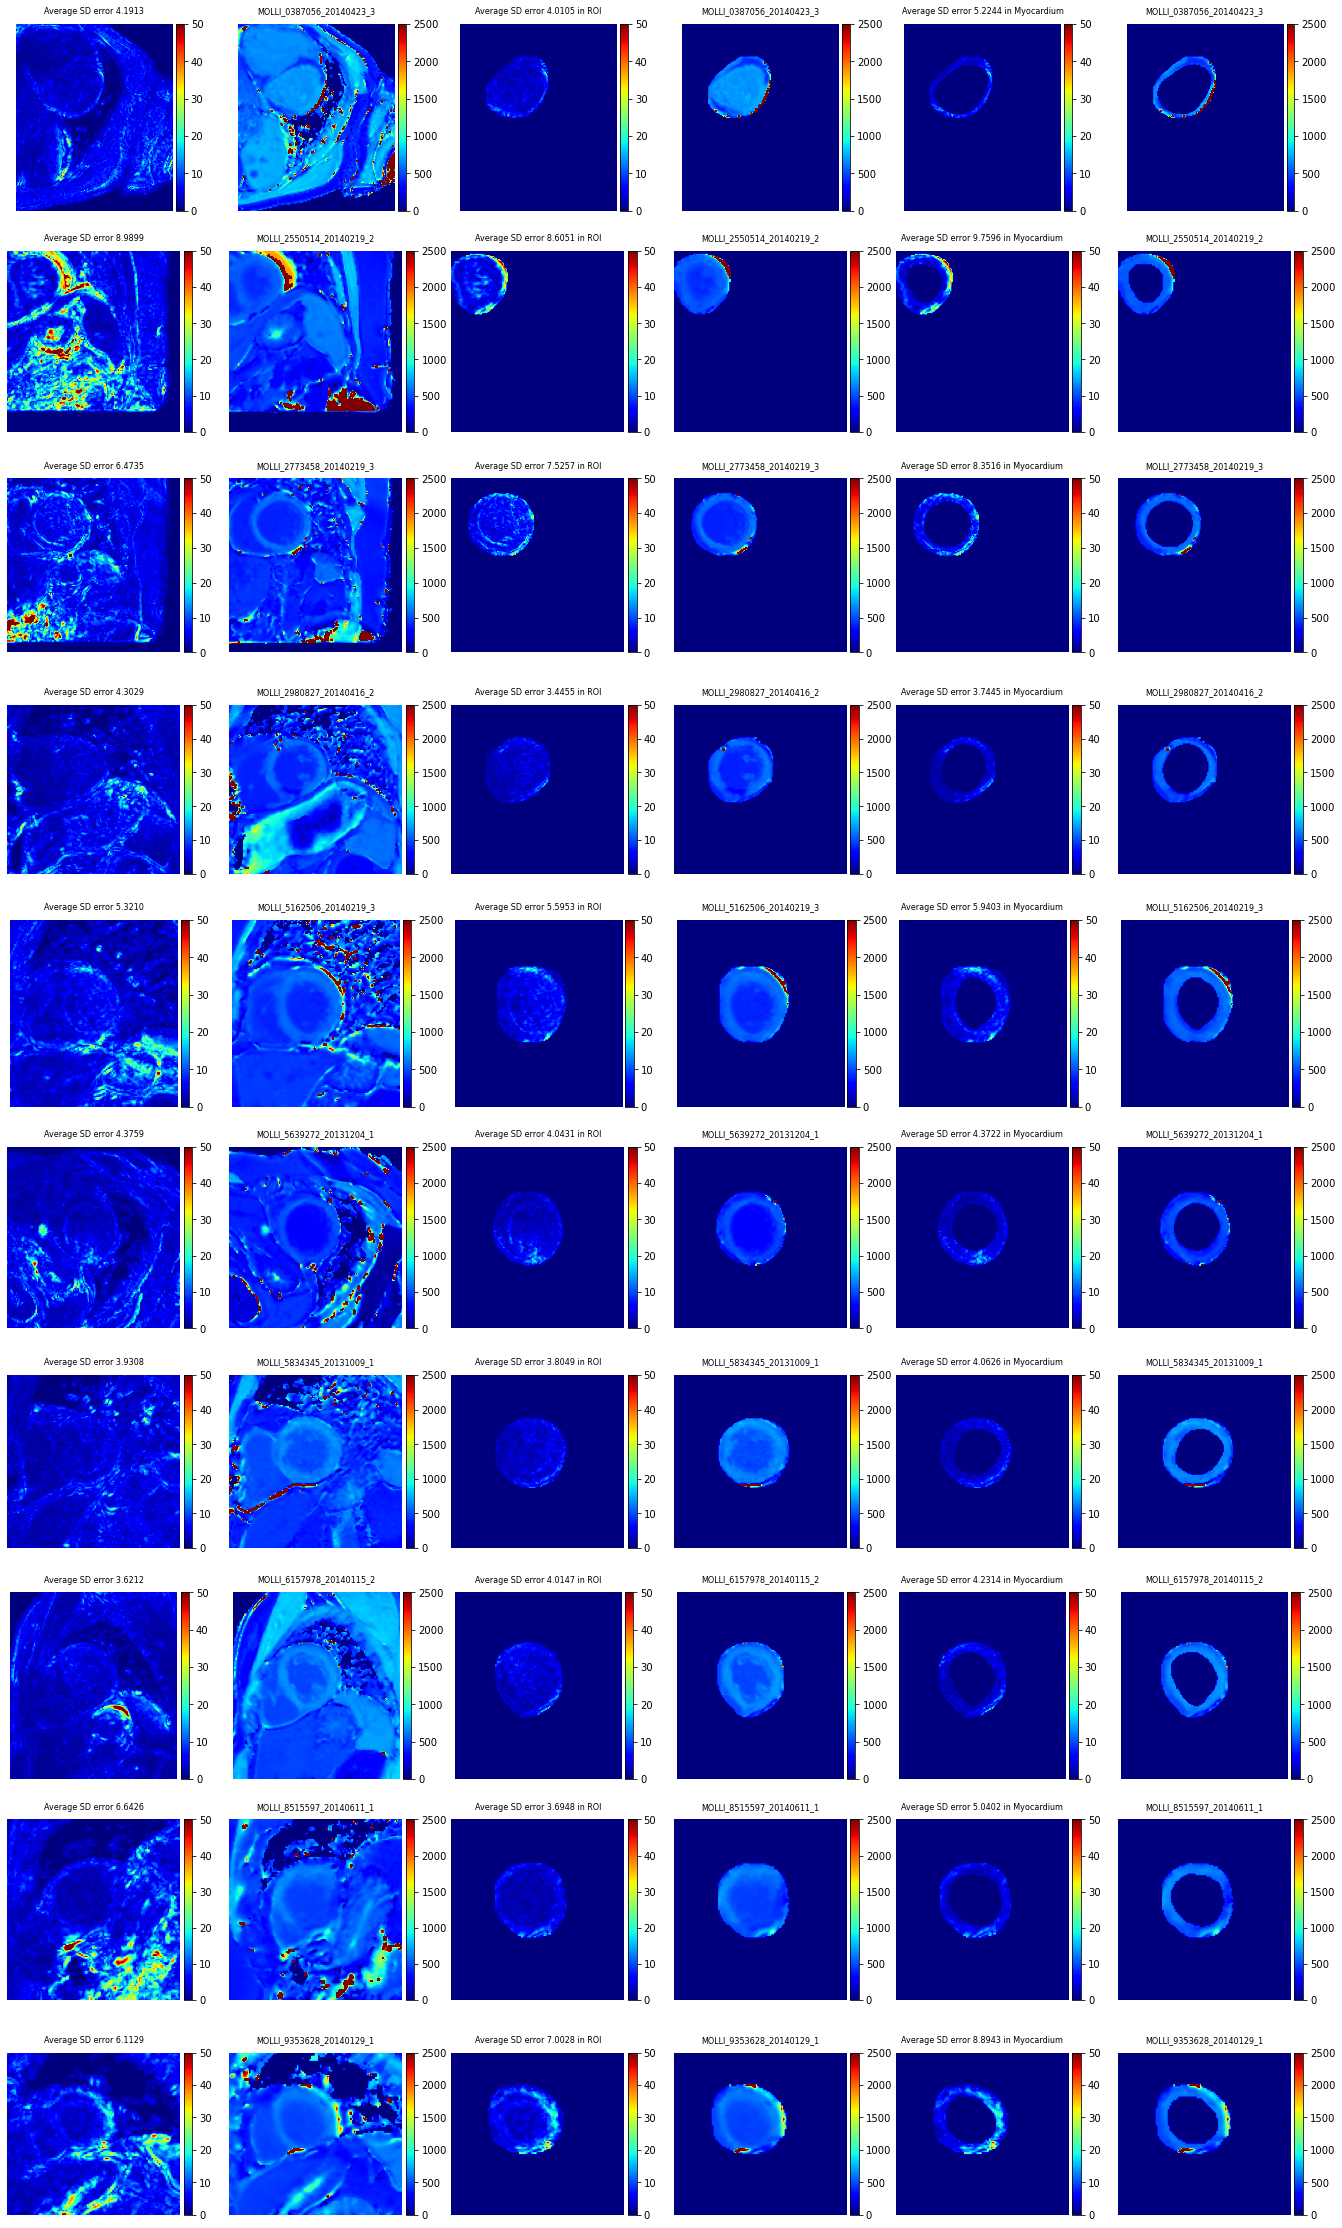

In [18]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R3 Square T1err'] = t1err_square_list
df['R3 ROI T1err'] = t1err_heart_list
df['R3 Myo T1err'] = t1err_myo_list
df_2['R3 PCA'] = pca_changes
df_2['R3 Det'] = mag_det_jac_det_list

### Round 4

In [19]:
r = 4
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [20]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8702123494042855 and std is 0.02025110325936334


#### Jacobian Determination

In [21]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.001292612636461854


#### T1 fitting

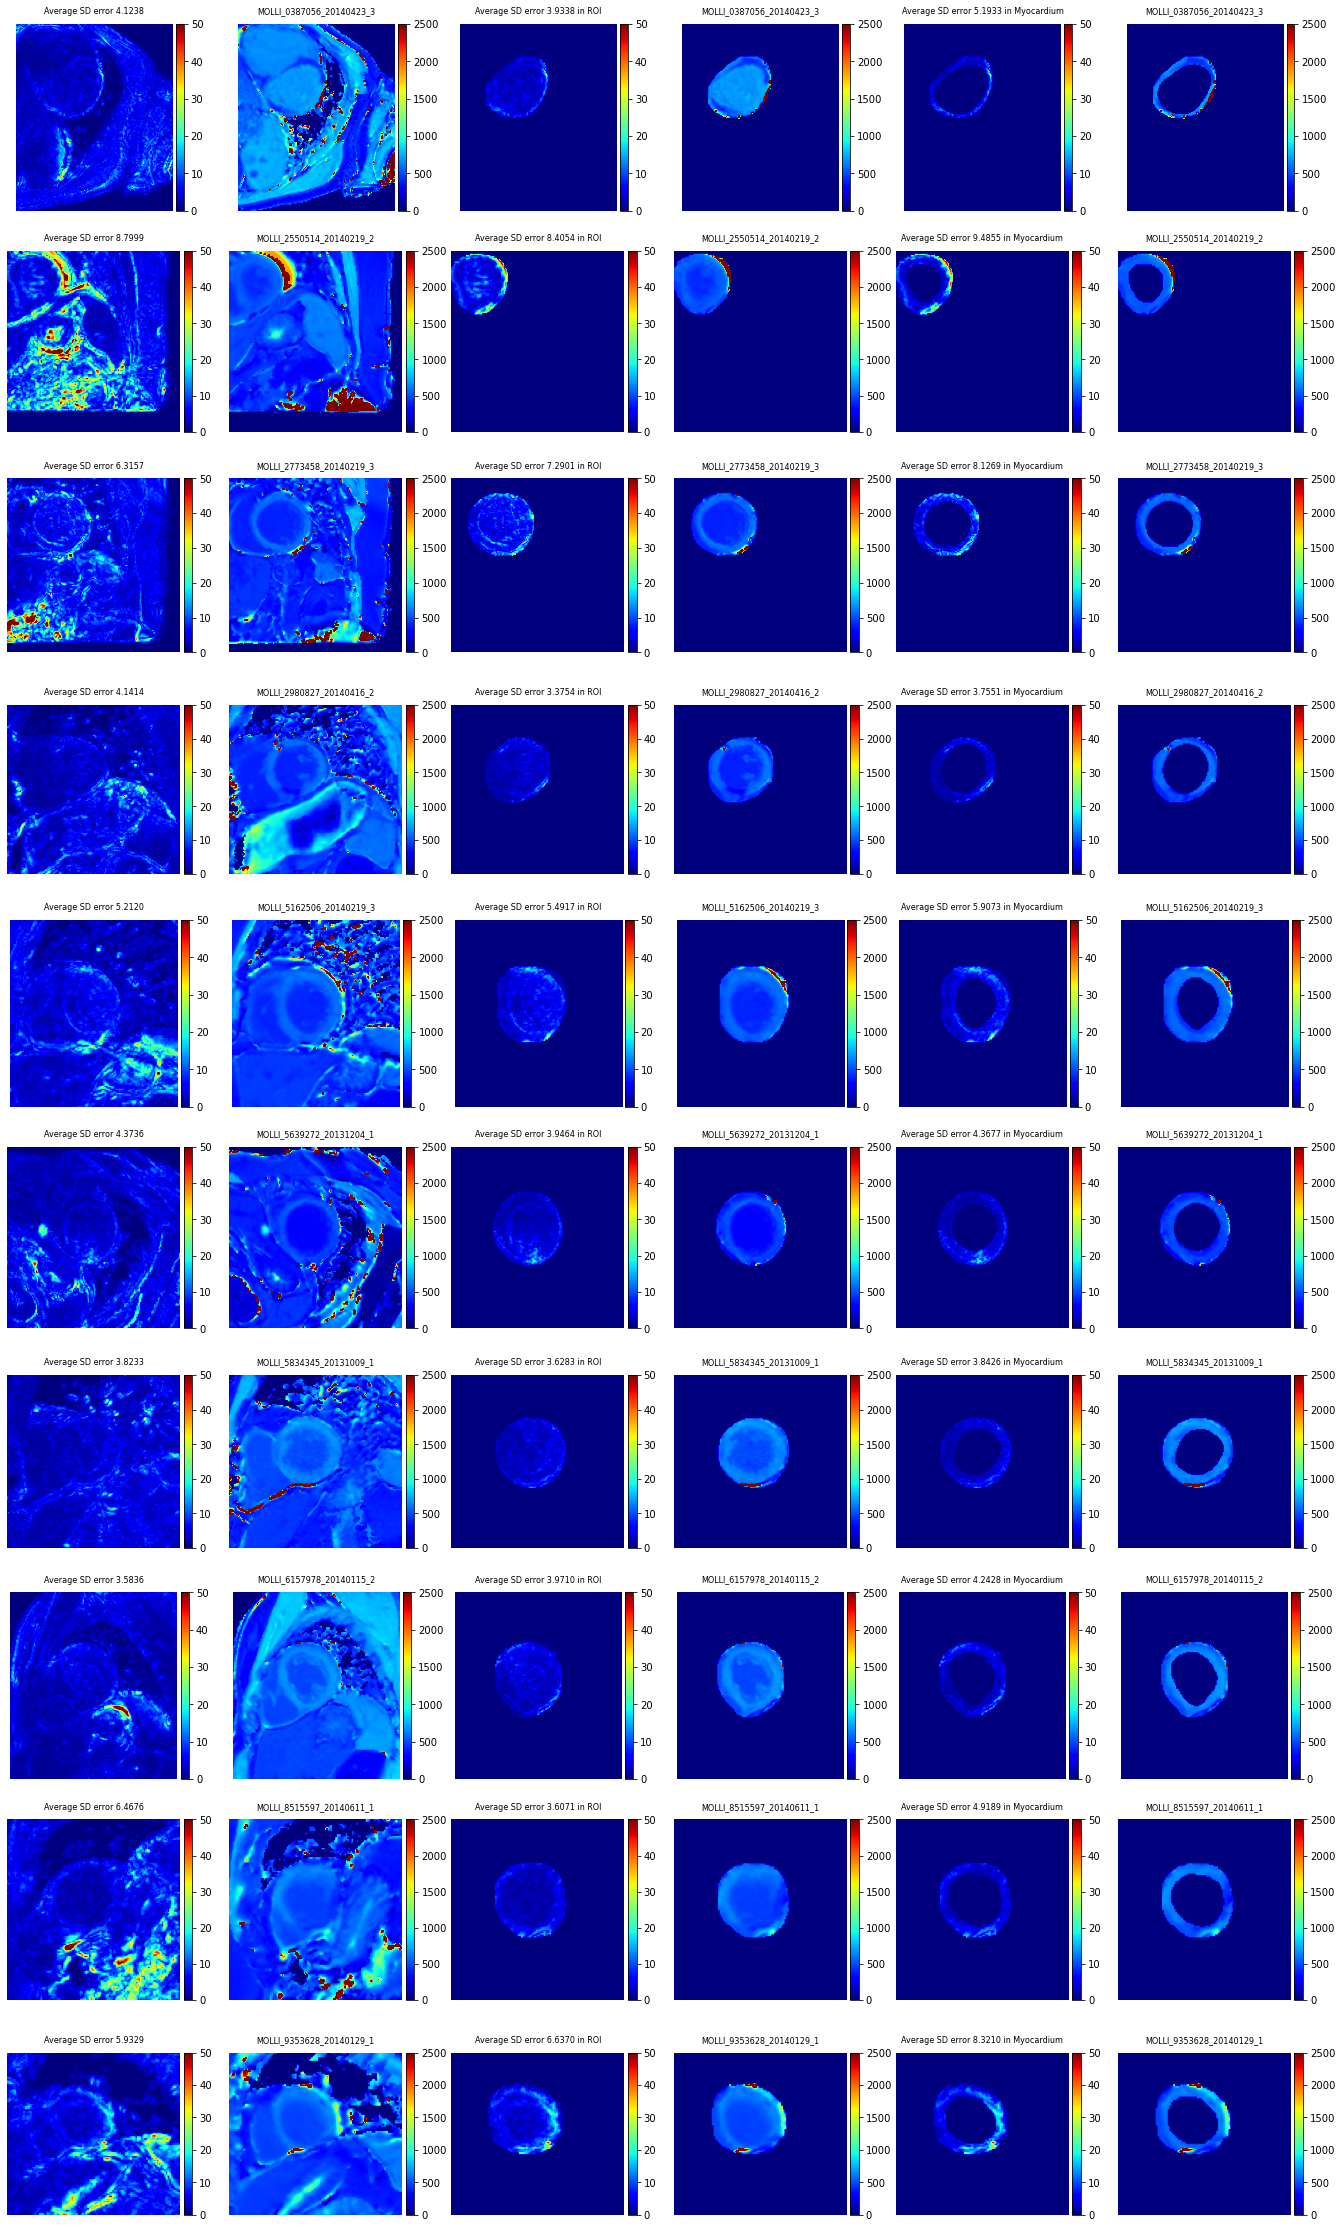

In [22]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R4 Square T1err'] = t1err_square_list
df['R4 ROI T1err'] = t1err_heart_list
df['R4 Myo T1err'] = t1err_myo_list
df_2['R4 PCA'] = pca_changes
df_2['R4 Det'] = mag_det_jac_det_list

### Round 5

In [23]:
r = 5
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [24]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8714907512217612 and std is 0.020203391510665688


#### Jacobian Determination

In [25]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0009905279148370028


#### T1 fitting

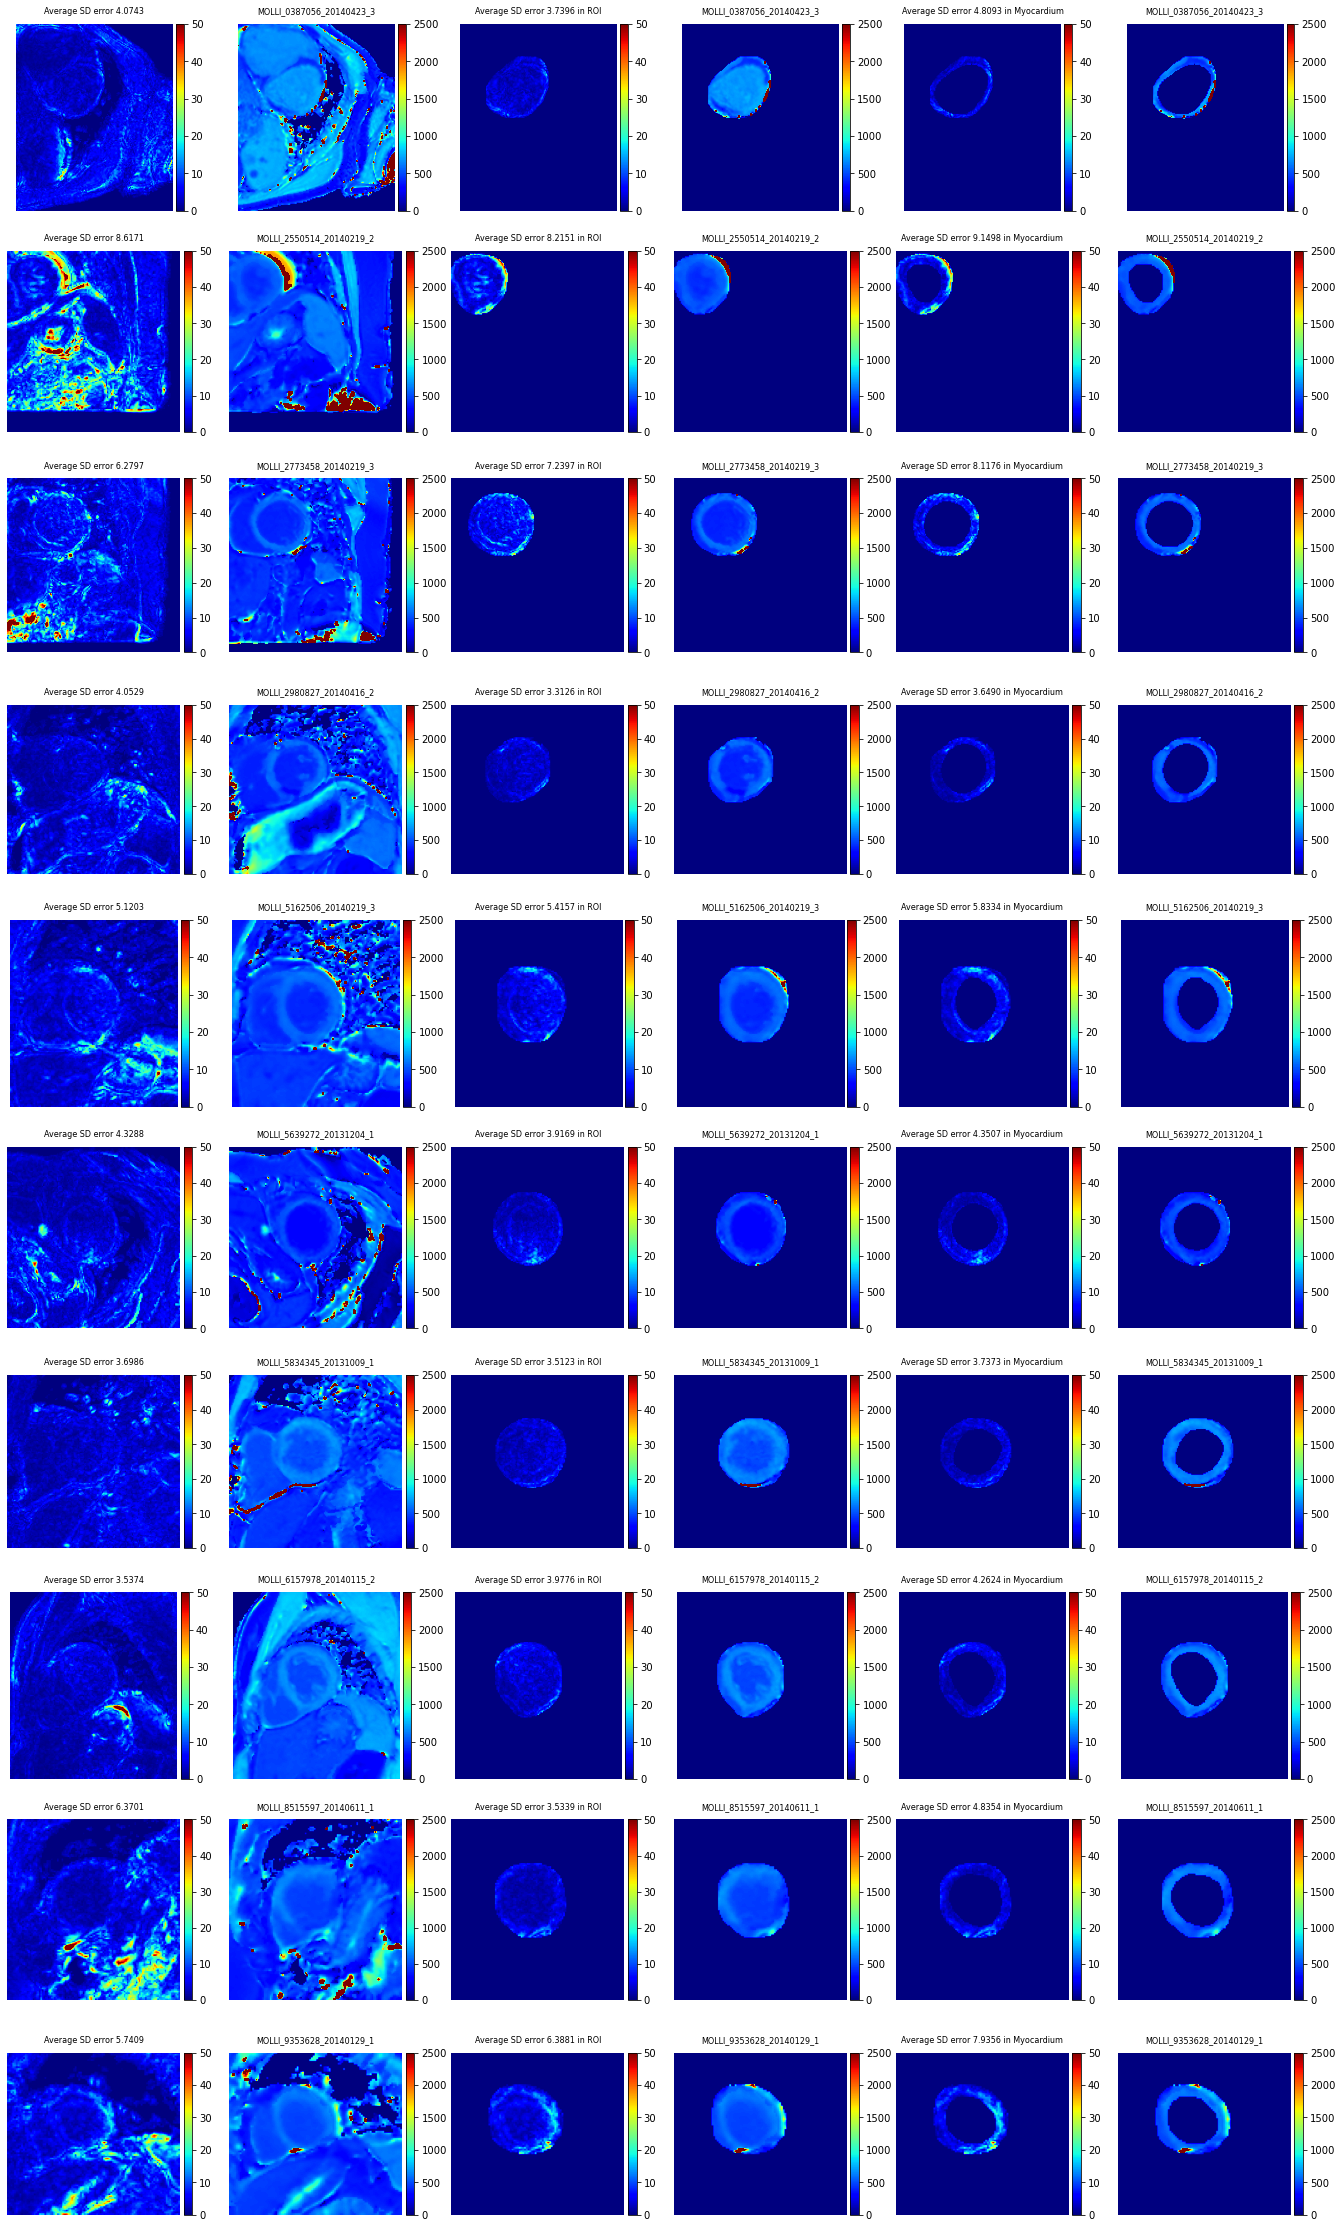

In [26]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R5 Square T1err'] = t1err_square_list
df['R5 ROI T1err'] = t1err_heart_list
df['R5 Myo T1err'] = t1err_myo_list
df_2['R5 PCA'] = pca_changes
df_2['R5 Det'] = mag_det_jac_det_list

### Round 6

In [27]:
r = 6
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [28]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8720423401182315 and std is 0.02018703028154919


#### Jacobian Determination

In [29]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0009966687066480517


#### T1 fitting

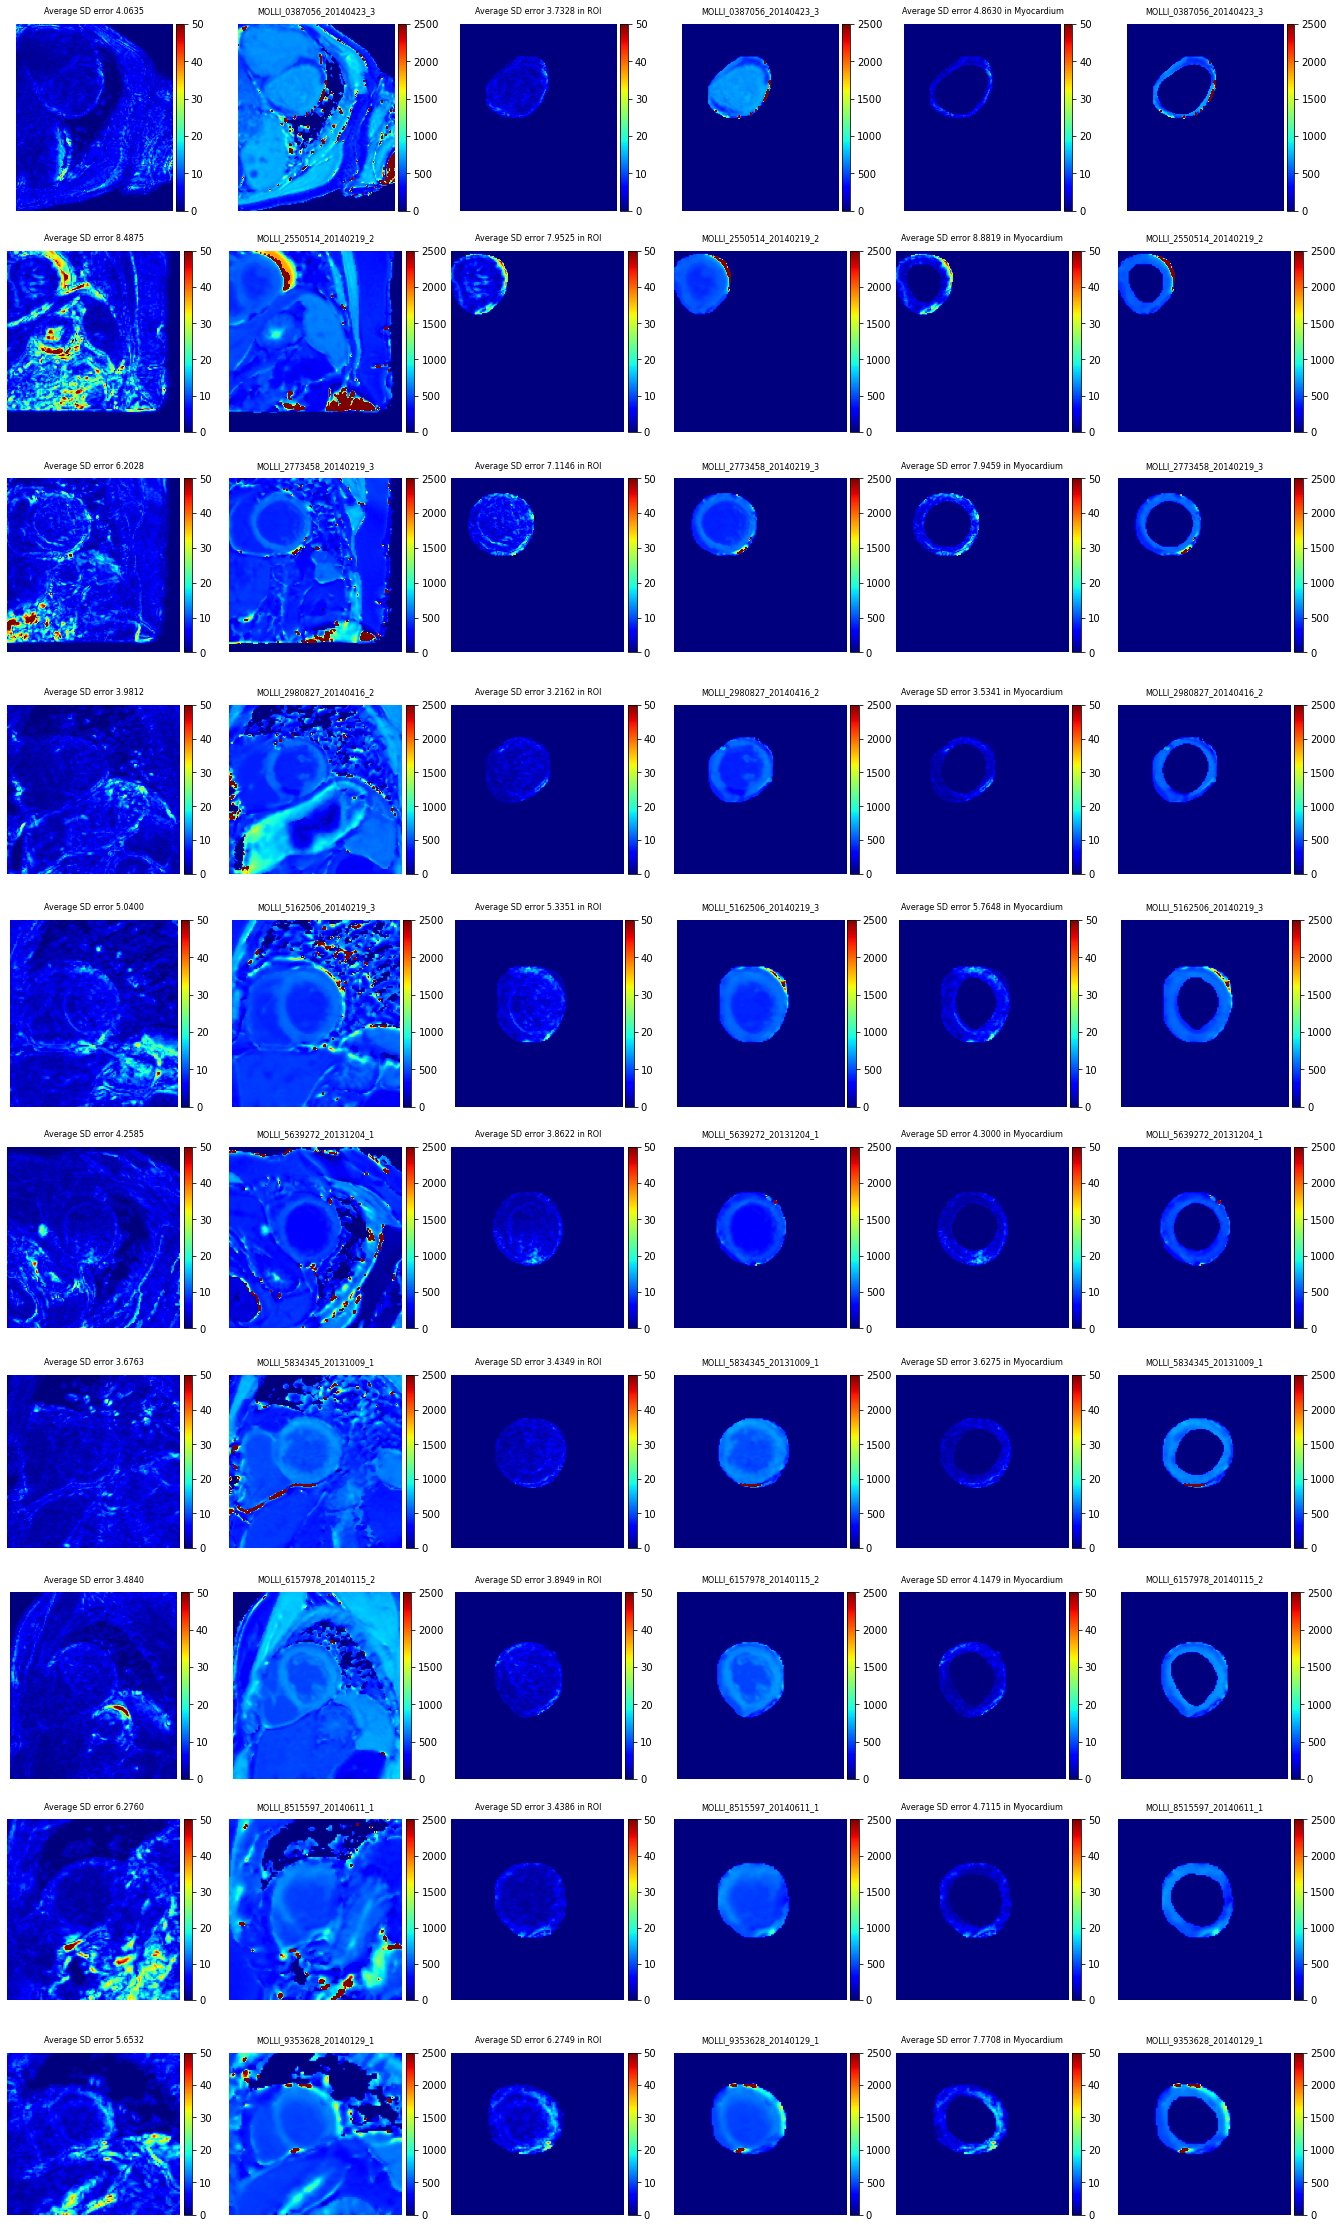

In [30]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R6 Square T1err'] = t1err_square_list
df['R6 ROI T1err'] = t1err_heart_list
df['R6 Myo T1err'] = t1err_myo_list
df_2['R6 PCA'] = pca_changes
df_2['R6 Det'] = mag_det_jac_det_list

### Round 7

In [31]:
r = 7
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [32]:
path = f"{base_path}/moved"
pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(pca_changes))} and std is {np.std(np.array(pca_changes))}")

Mean of Round 2 PCA is 0.8726709503488863 and std is 0.02014912914127684


#### Jacobian Determination

In [33]:
folding_ratio_list = []
mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0007817975129000843


#### T1 fitting

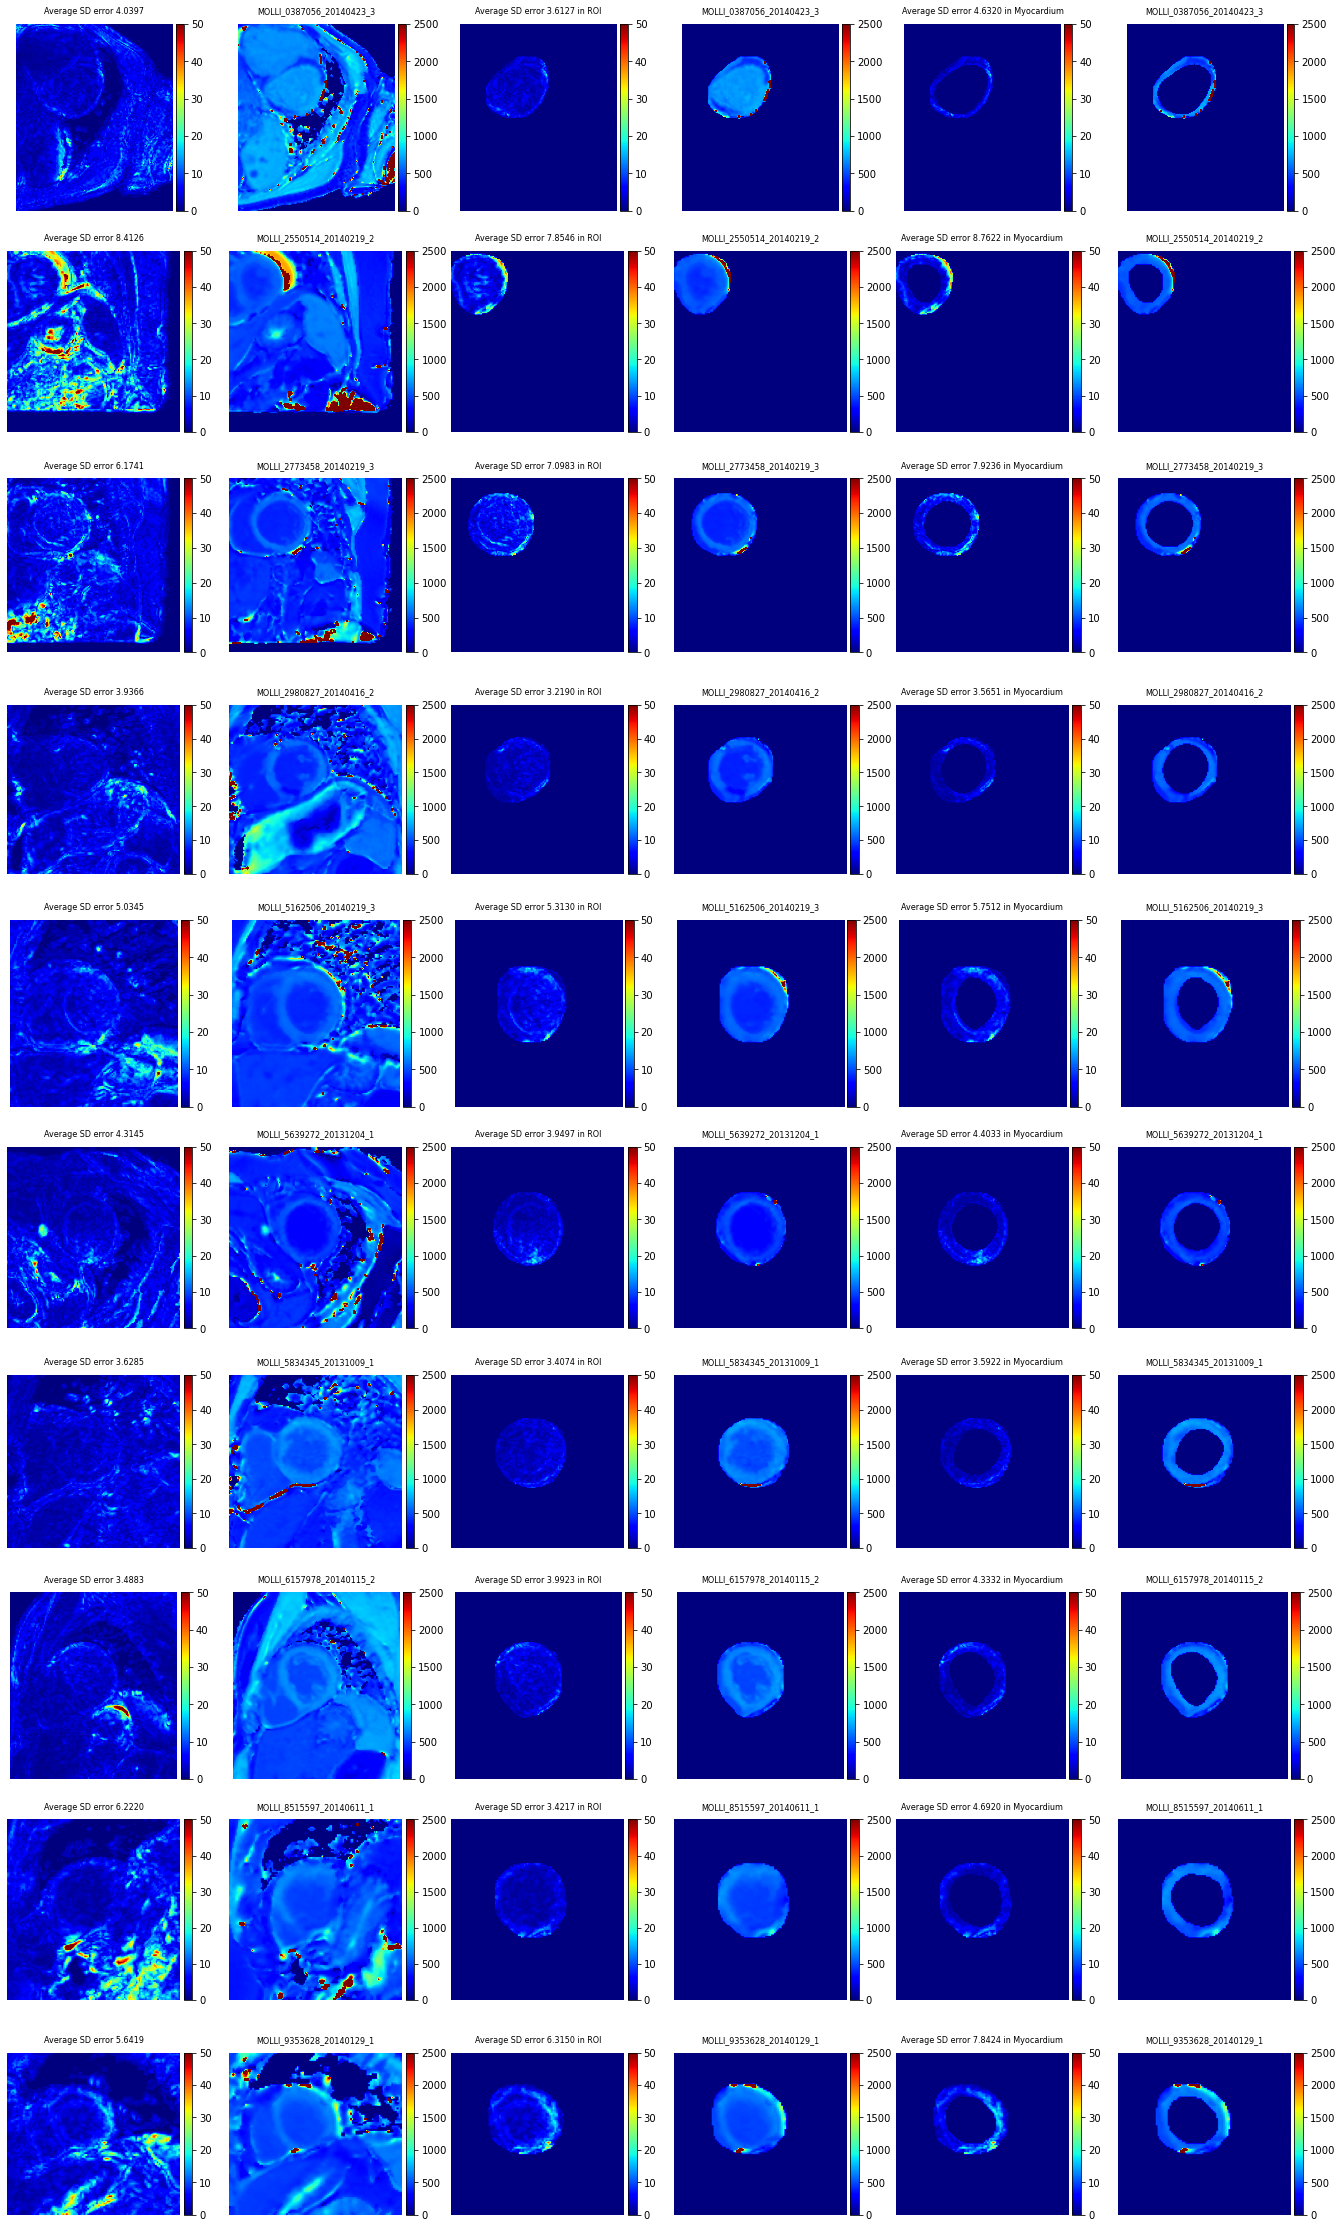

In [34]:
import matplotlib.pyplot as plt

path = f"{base_path}/T1_SDerr"

fig, subject_list, t1err_square_list, t1err_heart_list, t1err_myo_list = plot_t1_changes(path)
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

df['R7 Square T1err'] = t1err_square_list
df['R7 ROI T1err'] = t1err_heart_list
df['R7 Myo T1err'] = t1err_myo_list
df_2['R7 PCA'] = pca_changes
df_2['R7 Det'] = mag_det_jac_det_list

### Summary

In [35]:
df

Cases  Raw Square T1err  Raw ROI T1err  Raw Myo T1err  \
0  MOLLI_0387056_20140423_3          4.365528       4.750349       5.870213   
1  MOLLI_2550514_20140219_2         11.222237      11.078317      13.001846   
2  MOLLI_2773458_20140219_3          7.986917       9.714299      11.609513   
3  MOLLI_2980827_20140416_2          5.584256       4.158440       4.686161   
4  MOLLI_5162506_20140219_3          6.906262       6.659965       7.218737   
5  MOLLI_5639272_20131204_1          4.647820       4.714119       5.280648   
6  MOLLI_5834345_20131009_1          5.346733       4.869995       5.496672   
7  MOLLI_6157978_20140115_2          4.345653       5.046114       5.540035   
8  MOLLI_8515597_20140611_1          8.249505       4.466549       6.104468   
9  MOLLI_9353628_20140129_1          8.867598       9.884377      13.440048   

   R1 Square T1err  R1 ROI T1err  R1 Myo T1err  R2 Square T1err  R2 ROI T1err  \
0         4.242216      4.473947      5.739563         4.231854      4.253410   
1        10.398588     10.151410     11.782956         9.488101      9.260261   
2         7.006059      7.955895      8.837932         6.713779      7.706506   
3         4.905838      3.613241      3.794166         4.514653      3.519633   
4         5.962484      6.252621      6.796855         5.484610      5.827193   
5         4.629052      4.380333      4.940422         4.539439      4.107856   
6         4.523089      4.288557      4.706139         4.120408      3.930935   
7         3.923980      4.610769      4.814827         3.756791      4.272786   
8         7.480145      4.146565      5.656836         6.949598      3.864757   
9         7.618556      8.926402     11.841137         6.518218      7.783850   

   R2 Myo T1err  ...  R4 Myo T1err  R5 Square T1err  R5 ROI T1err  \
0      5.488085  ...      5.193289         4.074321      3.739561   
1     10.451263  ...      9.485517         8.617116      8.215068   
2      8.466313  ...      8.126855         6.279738      7.239750   
3      3.858802  ...      3.755129         4.052944      3.312601   
4      6.216612  ...      5.907344         5.120290      5.415651   
5      4.450461  ...      4.367685         4.328805      3.916923   
6      4.215705  ...      3.842650         3.698613      3.512255   
7      4.344942  ...      4.242753         3.537391      3.977597   
8      5.225509  ...      4.918860         6.370099      3.533940   
9      9.976722  ...      8.320967         5.740907      6.388087   

   R5 Myo T1err  R6 Square T1err  R6 ROI T1err  R6 Myo T1err  R7 Square T1err  \
0      4.809303         4.063485      3.732764      4.862981         4.039674   
1      9.149769         8.487521      7.952523      8.881921         8.412575   
2      8.117644         6.202785      7.114620      7.945945         6.174108   
3      3.649006         3.981235      3.216207      3.534081         3.936615   
4      5.833385         5.039964      5.335100      5.764769         5.034459   
5      4.350653         4.258536      3.862169      4.299960         4.314511   
6      3.737275         3.676307      3.434929      3.627536         3.628473   
7      4.262416         3.483967      3.894941      4.147926         3.488323   
8      4.835363         6.275951      3.438636      4.711464         6.222048   
9      7.935550         5.653205      6.274943      7.770758         5.641854   

   R7 ROI T1err  R7 Myo T1err  
0      3.612724      4.631962  
1      7.854565      8.762213  
2      7.098336      7.923556  
3      3.219001      3.565085  
4      5.313033      5.751172  
5      3.949666      4.403306  
6      3.407364      3.592177  
7      3.992336      4.333206  
8      3.421739      4.691967  
9      6.315019      7.842361  

[10 rows x 25 columns]

In [36]:
df_ROI_desc = pd.DataFrame()
df_ROI_desc['Cases'] = df['Cases']
for round in range(1, 8):
    df_ROI_desc[f'R{round}/Raw ROI %'] = (df['Raw ROI T1err'] - df[f'R{round} ROI T1err']) / df['Raw ROI T1err']
df_ROI_desc.describe()

R1/Raw ROI %  R2/Raw ROI %  R3/Raw ROI %  R4/Raw ROI %  R5/Raw ROI %  \
count     10.000000     10.000000     10.000000     10.000000     10.000000   
mean       0.096016      0.157599      0.196539      0.217826      0.233838   
std        0.038189      0.036475      0.045039      0.051279      0.054077   
min        0.058186      0.104611      0.142344      0.162854      0.169108   
25%        0.071014      0.130138      0.162760      0.178632      0.204752   
50%        0.084971      0.153435      0.188595      0.202733      0.212266   
75%        0.113773      0.185647      0.222117      0.247480      0.257525   
max        0.181012      0.212510      0.291531      0.328540      0.353719   

       R6/Raw ROI %  R7/Raw ROI %  
count     10.000000     10.000000  
mean       0.248832      0.249428  
std        0.054466      0.057319  
min        0.180723      0.162162  
25%        0.217305      0.213100  
50%        0.229133      0.236701  
75%        0.278519      0.285570  
max        0.365166      0.361111

In [37]:
df_Myo_desc = pd.DataFrame()
df_Myo_desc['Cases'] = df['Cases']
for round in range(1, 8):
    df_Myo_desc[f'R{round}/Raw Myo %'] = (df['Raw Myo T1err'] - df[f'R{round} Myo T1err']) / df['Raw Myo T1err']
df_Myo_desc.describe()

R1/Raw Myo %  R2/Raw Myo %  R3/Raw Myo %  R4/Raw Myo %  R5/Raw Myo %  \
count     10.000000     10.000000     10.000000     10.000000     10.000000   
mean       0.113497      0.185504      0.219976      0.234916      0.253528   
std        0.065498      0.062400      0.065944      0.078256      0.075696   
min        0.022256      0.065096      0.110016      0.115315      0.176114   
25%        0.066654      0.147293      0.175029      0.184804      0.195907   
50%        0.106357      0.186362      0.218573      0.216421      0.225969   
75%        0.140591      0.228713      0.258022      0.292599      0.299650   
max        0.238734      0.270743      0.338227      0.380883      0.409559   

       R6/Raw Myo %  R7/Raw Myo %  
count     10.000000     10.000000  
mean       0.267834      0.267539  
std        0.079133      0.079255  
min        0.171583      0.166143  
25%        0.208110      0.212663  
50%        0.248564      0.235310  
75%        0.316546      0.323933  
max        0.421821      0.416493

In [38]:
df_PCA_desc = pd.DataFrame()
df_PCA_desc['Cases'] = df_2['Cases']
for round  in range(1, 8):
    df_PCA_desc[f'R{round}/Raw PCA %'] = (df_2[f'R{round} PCA'] - df_2['Raw PCA']) / df_2['Raw PCA']
df_PCA_desc.describe()

R1/Raw PCA %  R2/Raw PCA %  R3/Raw PCA %  R4/Raw PCA %  R5/Raw PCA %  \
count     10.000000     10.000000     10.000000     10.000000     10.000000   
mean       0.006132      0.009391      0.009391      0.013107      0.014598   
std        0.002559      0.003571      0.003571      0.004565      0.004858   
min        0.002326      0.003393      0.003393      0.005555      0.006578   
25%        0.003926      0.006936      0.006936      0.009977      0.011434   
50%        0.006514      0.009439      0.009439      0.013174      0.014389   
75%        0.007994      0.011630      0.011630      0.015701      0.017560   
max        0.010342      0.015646      0.015646      0.021380      0.023750   

       R6/Raw PCA %  R7/Raw PCA %  
count     10.000000     10.000000  
mean       0.015241      0.015975  
std        0.004893      0.005028  
min        0.007097      0.007489  
25%        0.012106      0.012607  
50%        0.014839      0.015787  
75%        0.018367      0.019322  
max        0.024377      0.025170

In [39]:
df_det = df_2[['R1 Det', 'R2 Det', 'R3 Det', 'R4 Det', 'R5 Det', 'R6 Det', 'R7 Det']]
df_det.describe()

R1 Det     R2 Det     R3 Det     R4 Det     R5 Det     R6 Det  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.002129   0.001808   0.001808   0.001293   0.000991   0.000997   
std     0.000215   0.000112   0.000112   0.000068   0.000062   0.000062   
min     0.001822   0.001600   0.001600   0.001190   0.000871   0.000889   
25%     0.001982   0.001746   0.001746   0.001243   0.000948   0.000947   
50%     0.002131   0.001842   0.001842   0.001303   0.000999   0.001014   
75%     0.002279   0.001900   0.001900   0.001326   0.001032   0.001042   
max     0.002485   0.001929   0.001929   0.001416   0.001086   0.001085   

          R7 Det  
count  10.000000  
mean    0.000782  
std     0.000040  
min     0.000715  
25%     0.000762  
50%     0.000783  
75%     0.000805  
max     0.000847